# Complaint Routing Model

### by Jeffrey Strickland, Ph.D.
#### 30 November 2019

## Introduction
Banks are a prime example of businesses that already do or should take advantage of data science solutions to a variety of situations, including, but not limited to:
* Call routing for complex calls
* Call routing for complaints
* Quality control for regulatory compliance
* Customer sentiment analysis
* Fraudulent calls and other contacts

If we can select words and phrase from manuscripts or by actively monitoring calls, chats, and so on, then we can use past patterns to predict future behavior. We can also gauge customer sentiment when speaking to our best member service representatives (MSR), extract the words and phrases to characterize what "good looks like," and train other MSRs using the information we've obtained. Additionally, we can use the information to flag complex callers and route them to MSRs trained to address these situations. There are many other applications, but in this chapter, we will look at banks (financial services) we might deal with complaints about particular products or services, and (1) determine the product being complained about, and (2) predict future complains based on transcripts from past complaints.

### Goal: Properly route complaints based on product groups. 
Our goal is to produce a data science solution that routes text complaints to the correct complaint department for each product or service that the bank offers.

The bank's business unit receives complaints in the form of free text and wants to route the complaints to one of seven different complaint departments (with a product_group name in parenthesis):
	1. Bank account or service (bank_service)
	2. Credit card (credit_card)
	3. Credit reporting (credict_reporting)
	4. Debt collection (debt_collection)
	5. Lines of loans (loan)
	6. Money Transfers (money_transfers)
	7. Mortgage (mortgage)

We have obtained a data set with 286,362 records that contains complaint text (field name "text"), a message identifier ("complaint_id") and a verified correct complaint department ("product_group")

### Methodology

We have obtained a data set with 286,362 records that contains complaint text (field name "text"), a message identifier ("complaint_id") and a verified correct complaint department ("product_group").

To start, we will use a variety of techniques to explore and process the data, but will essentially follow the typical natural language processing (NLP) methodology, we discussed in Chapter 1:
1.	Sentence Tokenization
2.	Word Tokenization
3.	Text Lemmatization and Stemming
4.	Stop Words
5.	Regular Expression (Regex)
6.	Term Frequency-Inverse document Frequency (TF-IDF)
7.	Bag-of-Words (BOW)

In this analysis, we use TF-IDF for two different functions, n-gram extraction and model fitting. For corpus feature extraction, we will create five different classification models (or text classifiers) and compare them using a set of metrics. The classifiers include:
    - Multinomial Naïve Bayes
    - Multinomial Logistic Regression
    - Random Forest (RP)
    - Support Vector Machine (SVM)
    - Multi-layer Perceptron Classifier (neural network)

For peforming NLP, we will use the bag-of-words (BOW) method.

## Load Required Packages
As is the case with all of our Python usage so far, we preload packages we think we will need, as one style of doing it. This has several advantages: we will be prompted to load updates so that we are using the current ones; Some of the package are global (used throughout), like maplotlib; and  it helps us think about our process as we begin. We will also load packages as we need them, just to show how we do it.

In [1]:
#Standard packages
import pandas as pd
import numpy as np
import matplotlib

# Scikit Learn
from sklearn import preprocessing
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer 
from sklearn.model_selection import train_test_split, KFold

#Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatiser = WordNetLemmatizer()

#Plotting
from matplotlib import pyplot as plt
import seaborn as sns
# Allow plots in Notebook
%matplotlib inline

#Warning supression
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Optional Packages

In [2]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Plotly
import plotly
import plotly.graph_objects as go
import plotly.express as px
import chart_studio.plotly as py
import re
from sodapy import Socrata
from pprint import pprint

# Spacy for lemmatization
import spacy

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import seaborn as sns
#nltk.download('punkt')
#nltk.download('wordnet')

### Loading (reading) the Dataset using Pandas
Our first step in the modeling process is to load the data. In this instance the data is contained in a CVS file that we will read into the Jupyter Notebook.

In [3]:
dta = pd.read_csv("D:/Documents/Data/case_study_data_copy.csv")
df = dta[['complaint_id','product_group','text']]
corps = dta[['product_group','text']]

### Data Exploration
The next several step we take are for exploring the complaint data, including listing the headings, viewing some records, and assessing the shape of the data frame.

In [4]:
list(df), corps.shape

(['complaint_id', 'product_group', 'text'], (268380, 2))

In [5]:
df.head(5) # for showing a snapshot of the dataset

,complaint_id,product_group,text
0,2815595,bank_service,On check was debited from checking account and...
1,2217937,bank_service,opened a Bank of the the West account The acc...
2,2657456,bank_service,in nj opened a business account without autho...
3,1414106,bank_service,A hold was placed on saving account because in...
4,1999158,bank_service,Dear CFPBneed to send a major concerncomplaint...


## Prepare a Frequency Distribution

The next step consist of plotting the frequency of complaints for each product group and plotting the word counts

In [6]:
# Provides calculation of the shape of the data for each product group
bank_service_len = df[df['product_group'] == 'bank_service'].shape[0]
credit_card_len = df[df['product_group'] == 'credit_card'].shape[0]
credit_reporting_len = df[df['product_group'] == 'credit_reporting'].shape[0]
debt_collection_len = df[df['product_group'] == 'debt_collection'].shape[0]
loan_len = df[df['product_group'] == 'loan'].shape[0]
money_transfers_len = df[df['product_group'] == 'money_transfers'].shape[0]
mortgage_len = df[df['product_group'] == 'mortgage'].shape[0]

In [7]:
# Returns that complaint frequencies for each product group
bank_service_len, credit_card_len, credit_reporting_len, debt_collection_len, loan_len, money_transfers_len, mortgage_len 

(20071, 29553, 81234, 61471, 31036, 4734, 40281)

In [8]:
corps_freq = corps.groupby('product_group').text.count()
corps_freq

product_group
bank_service        20071
credit_card         29553
credit_reporting    81234
debt_collection     61471
loan                31036
money_transfers      4734
mortgage            40281
Name: text, dtype: int64

In [356]:
corps.groupby('product_group').product_group


## Plotting the Data

### Basic Histogram
For this plot we simply use plot.bar and group the categories by product_group.

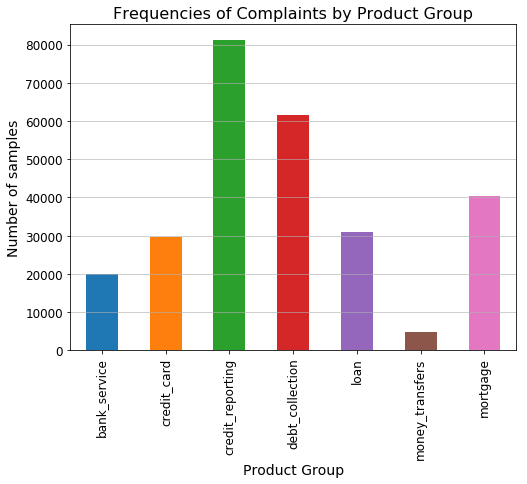

In [454]:
plt.figure(figsize=[8,6])
corps.groupby('product_group').text.count().plot.bar(ylim=0)
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Number of samples', fontsize=14)
plt.xlabel('Product Group', fontsize=14)
plt.title('Frequencies of Complaints by Product Group', fontsize=16)
plt.show()

### Histogram with Legend using Matplotlib Only
Here we use the categories we define above to add a legend, as well as chart title and axes labels.

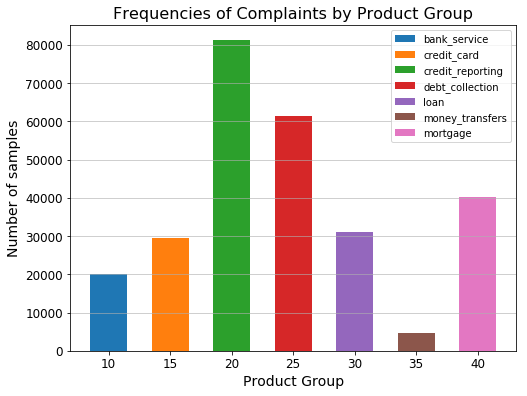

In [437]:
# Sets up the data for construct the frequency distribution (bar chart)
fig
plt.figure(figsize=[8,6])
plt.bar(10,bank_service_len,3, label="bank_service")
plt.bar(15,credit_card_len,3, label="credit_card")
plt.bar(20,credit_reporting_len,3, label="credit_reporting")
plt.bar(25,debt_collection_len,3, label="debt_collection")
plt.bar(30,loan_len,3, label="loan")
plt.bar(35,money_transfers_len,3, label="money_transfers")
plt.bar(40,mortgage_len,3, label="mortgage")
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Number of samples', fontsize=14)
plt.xlabel('Product Group', fontsize=14)
plt.title('Frequencies of Complaints by Product Group', fontsize=16)
plt.show()

## Store Product Group Data

The next step, and optional one, is to store the data for each product group into its own object for later use (potentially)

In [282]:
bks = df[df.product_group=="bank_service"]["text"].values
mtg = df[df.product_group=="mortgage"]["text"].values
crp = df[df.product_group=="credit_reporting"]["text"].values
ccd = df[df.product_group=="credit_card"]["text"].values
lon = df[df.product_group=="loan"]["text"].values
dct = df[df.product_group=="debt_collection"]["text"].values
mts = df[df.product_group=="money_transfers"]["text"].values

In [312]:
mtg[1], ccd[5]

("We paid off our mortgage with  on On the evening of received a letter stating that had to call them to cancel auto withdrawal of mortgage payment checked account and noticed that they had tried to withdraw the mortgage payment so we were charged insufficient funds charge called them and told them to cancel auto withdrawal On they tried to withdraw again We got another charge plus a recurring insufficient funds charge of So now we 're up to dollars in our account called  again and the girl kept saying have no record of your call you never told us not to take the money and there nothing we can do about it you need to put a stop payment on your account Also that they would refund the fees So called bank and told them what was happening and she told me that sure they could put stop payments on those amounts but it would cost for each At this point told her to close account She said she could close it until paid the fees ",
 ' received Double Cash credit card statement for the month of wh

In [12]:
X = corps['text']

In [13]:
y = corps['product_group']

## Label Encoding of Classes:

This is a classification problem where the classes are the seven product groups as already mentioned. In our dataset, the class labels are non-numeric (bank_services, credit_card, credit_reporting, debt_collection, loan, money_transfers, and mortgage). To perform some quick exploratoy analysis we use LabelEncoder from Scikit-Learn to make the classes numeric, starting from 0 depicting each label in the alphabetic order i.e., (0 → bank_services, 1 → credit_card, 2 → credit_reporting, 3 → debt_collection, 4 → loan, 5 → money_transfers, and 5 → mortgage).

In [378]:
# Importing necessary libraries
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
yL = labelencoder.fit_transform(y)

In [379]:
print(labelencoder.fit_transform(y))

[0 0 0 ... 6 6 6]


### Histogram of Procuct Groups using Labels
Now that we have a numeric represntation of the product groups, we can construct a histogram. For this, we will use two seperate plotting functions to provide a more informative histogram. First, we use pyplot from the matplotlib package to "outline" the histogram. Since are actegories are discrete, we add an sns distributioin plot that plots the actual discrete values.

C:\Users\jeff\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



Text(0,0.5,'Frequencies')

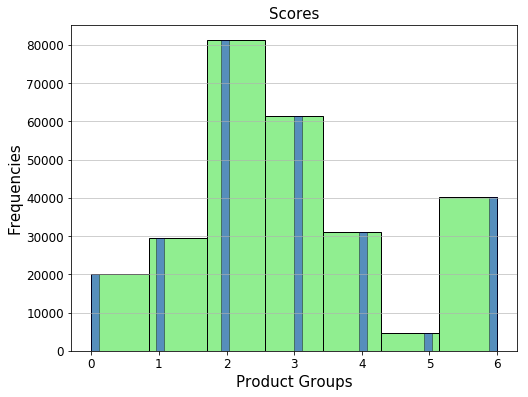

In [465]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.figure(figsize=[8,6])
plt.hist(yL, color = 'lightgreen', edgecolor = 'black',bins = 7)
# seaborn histogram
sns.distplot(yL, hist=True, kde=False, 
             bins=None, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Scores',fontsize=15)
plt.xlabel('Product Groups',fontsize=15)
plt.ylabel('Frequencies',fontsize=15)


## Basic Text Processing Steps:

1. Removal of Punctuation → All the punctuation marks are removed from all the text-snippets (instances or documents) from the dataset (corpus).
2. Removal of Stopwords → Stop-words are usually articles (a, an, the), prepositions (in, on, under, …) and other frequently occurring words that do not provide any key or necessary information. They are removed from all the text-snippets present in the dataset (corpus).
3. Returns a "clean" version of the text.

In [16]:
def text_prep(tex):

    # Check characters to see if they are in punctuation
    nopunc = [char for char in tex if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

## Word Cloud Visualization:

We developed the word clouds as follows:

- Product groups have their own unique words and phrases, as well as some common ones
- visualization of the mostly-used words to the least-used words for the product groups can be demonstrated
- Seven text snippets, each belonging to the seven product groups, respectively, can render a Word Cloud

In [338]:
# Importing necessary libraries
from PIL import Image
from wordcloud import WordCloud

wordcloud0 = WordCloud().generate(bks[1]) # for bank_service
wordcloud1 = WordCloud().generate(ccd[1]) # for credit_card
wordcloud2 = WordCloud().generate(crp[1]) # for credit_reporting 
wordcloud3 = WordCloud().generate(dct[1]) # for debt_collection 
wordcloud4 = WordCloud().generate(lon[1]) # for loan
wordcloud5 = WordCloud().generate(mts[1]) # for money_transfers
wordcloud6 = WordCloud().generate(mtg[1]) # for mortgage


Bank Service


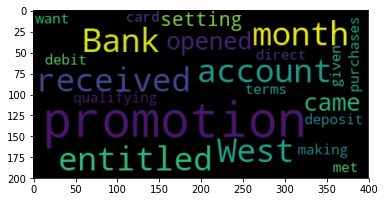

In [357]:
#print(X[0])
print('Bank Service')
plt.imshow(wordcloud0, interpolation='bilinear')
plt.show()

Credit Card


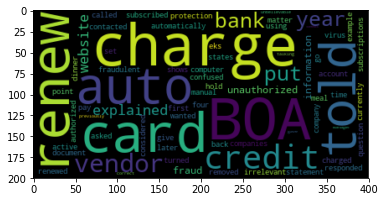

In [358]:
#print(X[22100])
print('Credit Card')
plt.imshow(wordcloud1, interpolation='bilinear')
plt.show()

Credit Reporting


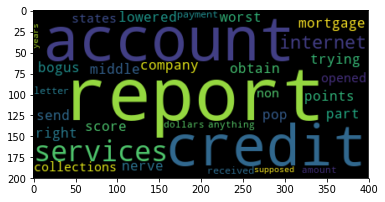

In [359]:
#print(X[42000])
print('Credit Reporting')
plt.imshow(wordcloud2, interpolation='bilinear')
plt.show()

Debt Collection


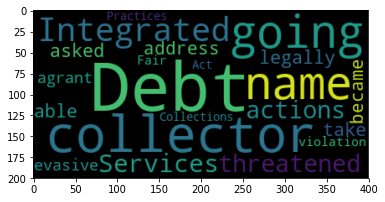

In [361]:
#print(X[152100])
print('Debt Collection')
plt.imshow(wordcloud3, interpolation='bilinear')
plt.show()

Loan


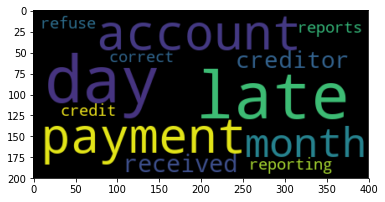

In [362]:
#print(X[199100])
print('Loan')
plt.imshow(wordcloud4, interpolation='bilinear')
plt.show()

Money Transfers


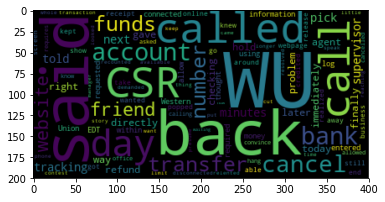

In [363]:
#print(X[227100])
print('Money Transfers')
plt.imshow(wordcloud5, interpolation='bilinear')
plt.show()

Mortgage


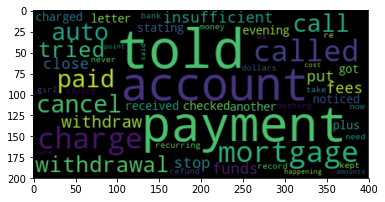

In [364]:
#print(X[237100])
print('Mortgage')
plt.imshow(wordcloud6, interpolation='bilinear')
plt.show()

## Natural Language Processing (NLP)
In this section we will examine how various natural language processing techniques can provide productive insights into large collections of text data. In this instance, we continue to analyze the complaint data but with much more robust measures and results. As we have already posed, NLP is the process of turning human speech (usually in written form) into language a computer can understand (numerical) using a program, extracting information from the numerical representation of the language, and turning it back into informative human language.

We looked at the basic text preparation steps in Chapter 1. We add four more step for featyre extraction here:
1. Remove punctuation
2. Remove special characters
3. Remove stop words
4. Tokenize the text
5. Lemmatize the text
6. Vectorize the text
7. Perform text transformations
8. Extract n-grams

Here, will make better use of the power of Python and supporting packages, like Scikit-Learn (sklearn). These 'utilities" allow us to take a given text or collection of texts, a corpus), remove punctuation, remove white-spaces, convert to lower case, remove common words that yield no information (stopwords) to produce a "clean" version of the text we want to analyze. we will begin by discussing stopwords.

### Stop Words
A stop word or stopword is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

There are several different ways to process text for stopwords with Python, including the Natural Language Tool Kit (NLTK) and Skikit-Learn (SKLearn). We could also build our own list and implement it by wring python code to remove stopwords using our list, of adapting a list and adding or taking from it for our use. However, processing text for stopwords is not simply a matter of pressing the Run button.

The are many existing stopwords lists and in many languages. In at least one of these lists is the word "computer," a word you may not want to remove, when analyzing text about competing technologies. Likewise, with save when analyzing retail banking issues. Stopwords from Skikit-Learn can be called after importing them, while NTLK stopwords are called within the CountVeterizor()function, which we will get to later in this section.

When we invoke stopwords with CountVectorizer, one of the arguments is, stopwords = None, as the default. If we want English stopwords, we merely add the argument, stopwords = 'english'.

#### Customized Stop Words
We will defer implementing the removal of stopwords until our discussion of CountVectorizer. For now, let's look at a list of stopwords I adapted from R. I added 'non-words' like "uh-huh", "um", "lol", and do on. In some settings, these might be appropriate words for analysis, but we usually exclude them and others like them.

In [26]:
stopwords = pd.read_csv("D:/Documents/Data/english_stopwords.txt")
print(stopwords)

Empty DataFrame
Columns: ['i',  'll',  'me',  'my',  'myself',  'we',  'our',  'ours',  'ourselves',  'you',  "you're",  "you've",  "you'll",  "you'd",  'your',  'yours',  'yourself',  'yourselves',  'he',  'him',  'his',  'himself',  'she',  "she's",  'her',  'hers',  'herself',  'it',  "it's",  'its',  'itself',  'they',  'them',  'their',  'theirs',  'themselves',  'what',  'which',  'who',  'whom',  'this',  'that',  "that'll",  'these',  'those',  'am',  'is',  'are',  'was',  'were',  'be',  'been',  'being',  'have',  'has',  'had',  'having',  'do',  'does',  'did',  'doing',  'a',  'an',  'the',  'and',  'but',  'if',  'or',  'because',  'as',  'until',  'while',  'of',  'at',  'by',  'for',  'with',  'about',  'against',  'between',  'into',  'through',  'during',  'before',  'after',  'above',  'below',  'to',  'from',  'up',  'down',  'in',  'out',  'on',  'off',  'over',  'under',  'again',  'further',  'then', ...]
Index: []

[0 rows x 183 columns]


In [25]:
# Importing necessary libraries
# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords

### Lemmatization
Inflected forms of a word are known as lemma. For example, "studying," "studied" are inflected forms or lemma of the word study which is the root word. So, the lemma of a word are grouped under the single root word. This is done to make the vocabulary of words in the corpus contain distinct words only.

Lemmatization is the process of converting a word to its base form. Lemmatization igoes beyond stemming, since lemmatization considers the context and converts the word to its meaningful base form--stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

### Create Train and Test Sets
Before we proceed further, we will setup training and testing sets that we will use for feature selection with the classification methods we pre-selected (Multinomial Naive Bayes, Support Vector Machines, etc.). Once we have these sets defined, with will begin working on feature extraction. 

We will use the Scikit-Learn modules model.selection.train_test_split to establish these sets. The module splits arrays or matrices into random train and test subsets, by setting the size (percentage) of the test set. Here we want a training set that is comprised by 70&% of the test data, with the remaining 30% held as the testing set. Also, we want to have separate sets for the text, X (complaints), and the categories, y (product groups), as we will only need to prepare the text, X, using NLP. We will separately prepare the dependent variable, y, converting the word-classes to numeric categories.

Apart from the import statement, the first for steps have been performed previously. We repeat them here to to refresh the data for our NLP work. This fifth line is the code for splitting X and y to for the train and ets sets.

In [28]:
from sklearn.model_selection import train_test_split
dta = pd.read_csv("D:/Documents/Data/case_study_data_copy.csv")
corps = dta[['product_group','text']]
X = corps.text
y = corps.product_group
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

### Feature Extraction
The Scikit-Learn module, sklearn.feature_extraction, can be used to extract features in a format supported by machine learning algorithms from datasets consisting of formats such as text and image. However, this is not the same thing as feature selection, which is our goal when modeling, particularly when we want to predict future outcomes based on past data and feature selection. In our analysis here, we are just examine the text to see features exist that could help classify the text (complaints) that are unique to each (or any) of the product groups.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Vectorization 
Vectorization is the process of converting data into a mathematical construct, like a vector, that can be easily manipulated without changing its content. Vectorization also speeds up computation. We usually evaluate the efficiency of a program by how fast it can manipulate large data sets in a relatively short time interval. Python uses mathematical functions for fast operations on entire arrays of data without having to write loops, and consequently produce results faster.

#### CountVectorizer
CountVectorizer converts text to word count vectors. It provides a simple way to both tokenize a collection of text documents, like our collection of complaints, and build a vocabulary of frequently used words, where the frequency can range from 1… n, known words. This vocabulary of known words can then be used to encode new related documents for analysis. In this manner, we can use a collection of text (complaints) to predict complaints based on this encoding. In our particular case, we will encode the text in such a manner as to not only predict complaints, but to categorize those complaints as belonging to one of the banks services/products, i.e., loans, credit cards, debt collection, and so on.
Here, we will use CountVectorizer to:
1.	Create an instance of the *CountVectorizer* function
2.	Call the *fit()* function to learn a vocabulary from one or more documents
3.	Call the *transform()* function on one or more documents as needed to encode each as a vector 

The pseudocode for this might appear as:
* Create the transform using vectorizer = CountVectorizer()
* Tokenize and build the vocabulary with vectorizer.fit(text)
* Summarized the results of vectorization using print(vectorizer.vocabulary_) [this function accesses the vocabulary to see what exactly was tokenized ]
* Encode the document with vector = vectorizer.transform(text)
* Summarize the encoded vector using print(vector.shape), print(type(vector)), and print(vector.toarray())

An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document, hence the “count” in vectorize. Now, these vectors will contain a lot of zeros, which we call them sparse vectors. However, Python provides an efficient way of handling sparse vectors using the *scipy.sparse* package. So, the vectors returned from a call to *transform()* function are sparse vectors, and we can transform them back to numpy arrays. We can then examine them to better understand what occurs by using the *toarray()* function.



In [29]:
from sklearn.feature_extraction.text import CountVectorizer

CountVectorizer(
    input='corps',            #the input text data or corpus
    encoding='utf-8',         #encoding is used to decode
    decode_error='strict',    #means a UnicodeDecodeError will be raised (other values are ignore and replace) 
    strip_accents='ascii',    #removes accents and perform other character normalization (ascii is the fastest)
    lowercase=True,           #converts all tect to lower case
    tokenizer=word_tokenize,  #default value is None (only applies if analyzer == 'word')
    stop_words='english',     #default value is None (only applies if analyzer == 'word')
    token_pattern=r'\b\w+\b', #string, denoting what constitutes a “token” (only used if analyzer == 'word')
    ngram_range=(1, 3),       #will yield unigrams, bigrams, and trigrams
    analyzer='word',          #feature makeup {‘string’, ‘word’, ‘char’, ‘char_wb’} or callable
    max_df=1.0,               #ignore terms that have a frequency higher than this threshold
    min_df=1,                 #ignore terms that have a frequency lower than this threshold
    max_features = 20,        #build a vocabulary size N or None
    binary=False,             #if True, all non zero counts are set to 1
    dtype= np.int64           #type of the matrix returned by fit_transform() or transform()
)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='corps',
        lowercase=True, max_df=1.0, max_features=20, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents='ascii', token_pattern='\\b\\w+\\b',
        tokenizer=<function word_tokenize at 0x00000219753A7378>,
        vocabulary=None)

#### Term Frequency–Inverse Document Frequency
The *TfidfTransformer* function transforms a count matrix to a normalized term frequency (tf) or term frequency times inverse document frequency (tf-idf ) representation. This is a common term weighting scheme in information retrieval, that has also found good use in document classification. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently. We use this transform because frequently occurring tokens in a given corpus are empirically less informative than features that occur in a small fraction of the training corpus.

The formula that is used to compute the tf-idf for a term *t* of a document *d* in a document set is *tf-idf(t, d) = tf(t, d) * idf(t)*, and the *idf* is computed as *idf(t) = log [ n / df(t) ] + 1* (if smooth_idf=False), where *n* is the total number of documents in the document set and *df(t)* is the document frequency of *t*; the document frequency is the number of documents in the document set that contain the term *t*. The effect of adding “1” to the idf in the equation above is that terms with zero *idf*, i.e., terms that occur in all documents in a training set, will not be entirely ignored. (Note that the *idf* formula above differs from the standard textbook notation that defines the *idf* as *idf(t) = log [ n / (df(t) + 1) ])*.

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer

TfidfTransformer(
    norm ='l2',          #each output row will have unit norm, either: 'l2', 'l1', or None
    use_idf=True,        #enable inverse-document-frequency reweighting
    smooth_idf=True,     #smooth idf weights by adding one to document frequencies to prevent divison by zero
    sublinear_tf=False,  #apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)
)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

### Naïve  Bayes Classification
Naïve Bayes is a very simple and reliable way to analyze how well text can be used to predict outcomes. In our case, we want to determine if the complaint data can be used to accurately classify and the predict the complaints by back services/product. In other words, can we use the present encoded complaint data to determine if a new complaint is correctly classified as a debt collect complaint, for example.

Here, we invoke yet another Scikit-Learn function, MultinomialNB(). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work, and we assume that here as well. MultinomialNB() has several functions:
* Fit function takes on two arguments: X, y or X-train, y_train when training a model.
* Get_params retrieves the parameters for this estimator.
* Predict function perform classification on an array of test vectors X, i.e., X_test.
* Predict_proba returns the probability estimates for the test vector X.
* Predict_log_proba returns the log-probability estimates for the test vector X
* Score function returns the mean accuracy on the given test data and labels.


In [31]:
from sklearn.naive_bayes import MultinomialNB

mnb_clf = MultinomialNB(
    alpha=1.0,        #additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
    class_prior=None, #prior probabilities of the classes. If specified, priors are not adjusted according to the data. 
    fit_prior=True    #whether to learn class prior probabilities or not, false = uniform prior will be used.
)

### Pipeline Definition
Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification.

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a '__', as in the example below. A step’s estimator may be replaced entirely by setting the parameter with its name to another estimator, or a transformer removed by setting it to 'passthrough' or None.

A Pipeline provides:
* Convenience and encapsulation: allows us to call fit and predict once on our data to fit a whole sequence of estimators.
* Joint parameter selection: allow us to grid search over parameters of all estimators in the pipeline at once.
* Safety: pipelines help avoid "leaking" statistics from our test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).

In [32]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf_trans', TfidfVectorizer()),
     ('mnb_clf', MultinomialNB()),
 ])

For our problem, we have already defined CountVectorizer(), TfidfTransformer(), and MultinomialNB(), so we could point to those functions with their represenations, e.g., tfidf.fit_transform(X_train). However, we will not need these until later. For now, we turn to an alternative approach.

### Product-to-Category and Category-to-Product Definition
If we were just concerned with generating information about complaints, we would not have to perform this step. We would merely call the n-grams from text with the CountVectorizer function. However, we want to encode the text in such a manner that we can identify complaints related to one of the bank services/products. Consequentially, we need to take the complaint about debt collection, and not only tokenize and transform the complaint text, but also assign a number to the category, debt collection. For example, the code we use below assigns 'zero' to the category 'bank services'. By calling the function category_to_id.items(), we can see all the category numeric assignments as shown below.

In [33]:
df = corps
df = df[pd.notnull(df['product_group'])]
df.columns = ['product_group','text']
df['category_id'] = df['product_group'].factorize()[0]
category_id_df = df[['product_group', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product_group']].values)
df.head()

,product_group,text,category_id
0,bank_service,On check was debited from checking account and...,0
1,bank_service,opened a Bank of the the West account The acc...,0
2,bank_service,in nj opened a business account without autho...,0
3,bank_service,A hold was placed on saving account because in...,0
4,bank_service,Dear CFPBneed to send a major concerncomplaint...,0


Again, by calling the function category_to_id.items(), we can see all the category numeric assignments:

In [34]:
category_to_id.items()

dict_items([('bank_service', 0), ('credit_card', 1), ('credit_reporting', 2), ('debt_collection', 3), ('loan', 4), ('money_transfers', 5), ('mortgage', 6)])

### TfidfVectorizer
This feature extraction function converts a collection of raw documents to a matrix of TF-IDF features. It is equivalent to invoking CountVectorizer followed by TfidfTransformer. The parameters for the function are the combined parameters from CountVectorizer and TfidfTransformer with the same definitions. For this problem, it makes more sense to use the TfidfVectorizer function. The reason for this is the process of extracting n-grams from the text requires the greater functionality provided, as we will want to use the same construct to define "features" and to pull "feature names" from. (See Extracting N-grams, below.)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

TfidfVectorizer(
    input='corps',            #the input text data or corpus
    encoding='utf-8',         #encoding is used to decode
    decode_error='strict',    #means a UnicodeDecodeError will be raised (other values are ignore and replace) 
    strip_accents='ascii',    #removes accents and perform other character normalization (ascii is the fastest)
    lowercase=True,           #converts all tect to lower case
    tokenizer=word_tokenize,  #default value is None (only applies if analyzer == 'word')
    stop_words='english',     #default value is None (only applies if analyzer == 'word')
    token_pattern=r'\b\w+\b', #string, denoting what constitutes a “token” (only used if analyzer == 'word')
    ngram_range=(1, 3),       #will yield unigrams, bigrams, and trigrams
    analyzer='word',          #feature makeup {‘string’, ‘word’, ‘char’, ‘char_wb’} or callable
    max_df=1.0,               #ignore terms that have a frequency higher than this threshold
    min_df=1,                 #ignore terms that have a frequency lower than this threshold
    max_features = 20,        #build a vocabulary size N or None
    binary=False,             #if True, all non zero counts are set to 1
    dtype= np.int64,          #type of the matrix returned by fit_transform() or transform()
    norm='l2',                #each output row will have unit norm, either: 'l2', 'l1', or None
    use_idf=True,             #enable inverse-document-frequency reweighting
    smooth_idf=True,          #smooth idf weights by adding one to document frequencies to prevent divison by zero
    sublinear_tf=False,       #apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)
)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='corps',
        lowercase=True, max_df=1.0, max_features=20, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='ascii', sublinear_tf=False,
        token_pattern='\\b\\w+\\b',
        tokenizer=<function word_tokenize at 0x00000219753A7378>,
        use_idf=True, vocabulary=None)

### Extracting N-Grams
Extracting N-grams is made easy using CountVectorizer() and TfidfVectorizer(). However, this problem requires a little more beyound merely calling N-grams, or extracting features. For this problem, we want to get N-grams for each complait category, i.e., bank servic, debt collection, and so on. We have already set ourselves up for success in the previous section on Product-to-Category and Category-to-Product Definition, as well as the vectorization we have already performed. Where one may run into difficulties implementing this technique is to not pay attention to dimensions or shapes after vectorization, as the vectors are going to be operated on using matrix algebra, and dimension must have the right shape for the resulting veatcor. This error would be most likely to occur in the first statement under the "for product group...

In [36]:
#DO NOT CHANGE#
tfidf= TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(X_train) #CORRECT TRANSFORM
labels = y_train #CORRECT LABEL

In [37]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for product_group, category_id in sorted(id_to_category.items()):
  features_chi2 = chi2(features,labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(category_id))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n.  {}".format('\n. '.join(bigrams[-N:])))
  print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# 'bank_service':
  . Most correlated unigrams:
. deposit
. overdraft
  . Most correlated bigrams:
.  overdraft fees
. checking account
  . Most correlated trigrams:
. charged overdraft fees
. opened checking account
# 'credit_card':
  . Most correlated unigrams:
. express
. card
  . Most correlated bigrams:
.  american express
. credit card
  . Most correlated trigrams:
. credit card account
. credit card company
# 'credit_reporting':
  . Most correlated unigrams:
. experian
. equifax
  . Most correlated bigrams:
.  credit file
. credit report
  . Most correlated trigrams:
. mistakes appear report
. appear report understanding
# 'debt_collection':
  . Most correlated unigrams:
. collection
. debt
  . Most correlated bigrams:
.  collect debt
. collection agency
  . Most correlated trigrams:
. attempting collect debt
. trying collect debt
# 'loan':
  . Most correlated unigrams:
. loans
. navient
  . Most correlated bigrams:
.  student loans
. student loan
  . Most correlated trigrams:
.

## Bag-of-Words (BOW) Preparation

### About Bag of Words
A bag-of-words (BOW) is basically the procedure we have been been performing:
1. Clean the text
2. Tokenize the text
3. Build a vocabulary from the text
4. Generate vextors from the text

With Bag-of-Words a vocabulary of words present in the corpus is maintained, and these words serve as features for each instance or document (each complaint). For words in the current document, we use their frequencies to develop features with NLP. In this way word features are engineered or extracted from the textual data or corpus.

### Feature Engineering using Bag-of-Words
To develop feature from text is a very relevant issue for data science. Machine Learning Algorithms work only on numeric data, but for the problem we are solving, data is present in the form of text only. to perform our analysis, textual data needs to be transformed into numeric form. We call this process Feature Engineering. In this approach, numeric features are extracted or engineered from textual data. There are many Feature Engineering Techniques in existence, but for this problem we will use the Bag-of-Words model to engineer features.

We have already seen the process of cleaning data using feature extraction function from Scikit-Learn, and we will use these function again, which is repeative, but the best way to learn something is to do it more than once. In particular, we will use TfidfTransformer() and CountVectorizer() with the complaint data and the training and test sets we have aleady defined. 

#### Prepare theTraining Sets
First, we define CountVectorizer() and use it to get a count vector of words, as we did before, but performing the transform fit using y_train. This will allow us to pull the bank service and products. 

In [38]:
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(y_train)
print(vectorizer.get_feature_names())

['bank_service', 'credit_card', 'credit_reporting', 'debt_collection', 'loan', 'money_transfers', 'mortgage']


Second, we define TfidfTransformer() and perform a fit with it. There are a couple of ways to prepare for using this function. One way is to perform a fit, which learns the IDF, and then perform a transform with the fitted function, which transforms a count matrix to a TF or TF-IDF representation. Stepping through this process follows this logic:
1. Use TfidfTransformer() to perform a fit of X_train_counts
2. Use the TfidfTransformer() fit to perform a transform on X_train_count
3. Verify the shape

In [39]:
from sklearn.feature_extraction.text import TfidfTransformer
# Step 1
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)

# Step 2
X_train_tf = tf_transformer.transform(X_train_counts)

# Step 3
X_train_tf.shape

(187866, 7)

Next, we use TfidfTransformer(), but to perform a fit_tranform operation, which fits the data, and then transform it.

In [40]:
tfidf_trans = TfidfTransformer()
X_train_tfidf = tfidf_trans.fit_transform(X_train_counts)
X_train_tfidf.shape

(187866, 7)

#### Fit a Naive Bayes Classifier
Finally, we define the MultinomialNB() to perform a fit of X_train and y_train, which we use as a classifier model.

In [41]:
from sklearn.naive_bayes import MultinomialNB
mnb_clf = MultinomialNB().fit(X_train_tfidf, y_train)
print(mnb_clf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


#### Prepare the Test Sets
Now we repeat the preparation process that we just followed, but using the test sets, first vectorize X_test and then transforming this result using tfidf_trans.transform(). We would then use these results to test/verify our mnb_clf model. But we will perform the complete technique using a Pipeline.

In [42]:
X_test_counts = vectorizer.transform(X_test)
X_test_tfidf = tfidf_trans.transform(X_test_counts)

In [43]:
predicted = mnb_clf.predict(X_test_tfidf)

In [44]:
predicted

array(['credit_reporting', 'credit_reporting', 'credit_reporting', ...,
       'credit_reporting', 'credit_reporting', 'loan'], dtype='<U16')

#### Bag-of-Words Model
For simplicity, we will continue to use CountVectorizer(), but we'll name the output suing "bow" in the name. For example, the vectorizer with become "bow_transformer", and the X_train data will become "text_bow_train". Otherwise, the procedure is the same, except that we add so called "confusion matrices" to further visualize and analyze performance.

In [45]:
vectorizer = CountVectorizer()
bow_transformer_train=CountVectorizer().fit(X_train)
bow_transformer_test=CountVectorizer().fit(X_test)

bow_transformer=vectorizer.fit(X_train)
text_bow_train=bow_transformer.transform(X_train)#ONLY TRAINING DATA
text_bow_test=bow_transformer.transform(X_test)#ONLY TEST DATA

In [46]:
# instantiating the model with Multinomial Naive Bayes..
mnb_clf = MultinomialNB()

# training the model...
mnb_clf = mnb_clf.fit(text_bow_train, y_train)


In [47]:
mnb_clf.score(text_bow_train, y_train)

0.8205210096558185

Now that we have the pipeline defined, we use it to fit the mnb_clf model, test its predictions, and measure its accuracy and performance. Notice that we only need to call the 'mnb_clf' from the pipeline both to fit and predict. Then, we check the accuracy of our predictions using the mean value (from the numpy package).

In [48]:
# Predict Outcomes using the MultinomialNB() model
predicted = mnb_clf.predict(text_bow_test)

In [49]:
mnb_clf.score(text_bow_test, y_test)

0.8103683831383361

Next, we conduct a more comprehensive performance test comprised of precision, recall, support, and f1-score metrics.

In [88]:
from sklearn import metrics
vectorizer = CountVectorizer()
y_test_counts = vectorizer.fit_transform(y_test)
features = vectorizer.get_feature_names()

In [89]:
print(metrics.classification_report(y_test, predicted, target_names=features))

                  precision    recall  f1-score   support

    bank_service       0.77      0.73      0.75      5999
     credit_card       0.77      0.70      0.74      8847
credit_reporting       0.83      0.87      0.85     24445
 debt_collection       0.81      0.80      0.81     18481
            loan       0.74      0.76      0.75      9314
 money_transfers       0.73      0.69      0.71      1422
        mortgage       0.90      0.88      0.89     12006

     avg / total       0.81      0.81      0.81     80514



### BOW Analysis with a Support Vector Machine (SVM)
Now, that we know that a model can be fitted to predict complaint outcomes, we want to try using what might be a more rigorous model, a support vector machine (SVM). As we dd before, we use a pipeline to prepare the data and to define the model

In [76]:
from sklearn.linear_model import SGDClassifier

svm_clf = Pipeline([
     ('vect', vectorizer),
     ('tfidf', TfidfTransformer()),
     ('svm_clf', svm.LinearSVC()),
 ])

In [85]:
from sklearn import svm
svm_clf = svm.LinearSVC()
svm_clf.fit(text_bow_train, y_train)
svm_score = svm_class.score(text_bow_train, y_train)
svm_score

0.9385146859995954

In [86]:
predicted = svm_clf.predict(text_bow_test)
np.mean(predicted == y_test)

0.8133119705889659

#### Confusion Matrices
The mean value for the SVM is better than that of the NBM, so we go an extra step in measuring its performance. Here we use what is called a "confusion matrix." A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm, which is the SVM in this case. The confusion matrix itself is relatively simple to understand, but the related terminology can be confusing.

You may have heard these terms before, perhaps in a probability and statistics course.

1. True Positive: You predicted positive and it’s true, i.e., you predicted that a complaint corresponds to a loan and it actually is.

2. True Negative: You predicted negative and it’s true, i.e., you predicted that a complaint does not corresponds to a loan and it actually is not.

3. False Positive: (Type 1 Error) You predicted positive and it’s false, i.e.  you predicted that a complaint corresponds to a loan and it actually is not.

4. False Negative: (Type 2 Error) You predicted negative and it’s false. i.e.  you predicted that a complaint does not correspond to a loan and it does.

Remember, we describe predicted values as Positive and Negative and actual values as True and False.

                  precision    recall  f1-score   support

    bank_service       0.77      0.73      0.75      5999
     credit_card       0.77      0.70      0.74      8847
credit_reporting       0.83      0.87      0.85     24445
 debt_collection       0.81      0.80      0.81     18481
            loan       0.74      0.76      0.75      9314
 money_transfers       0.73      0.69      0.71      1422
        mortgage       0.90      0.88      0.89     12006

     avg / total       0.81      0.81      0.81     80514



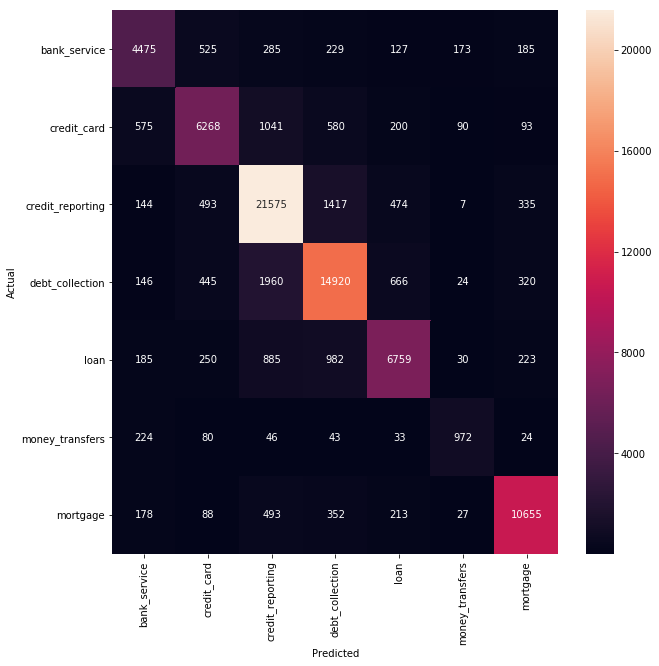

In [90]:
#svm_class = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
svm_clf.fit(text_bow_train, y_train)
y_pred = svm_clf.predict(text_bow_test)
features = vectorizer.get_feature_names()
print(metrics.classification_report(y_test, predicted, target_names=features))
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=features, yticklabels=features)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [91]:
print(conf_mat)

[[ 4475   525   285   229   127   173   185]
 [  575  6268  1041   580   200    90    93]
 [  144   493 21575  1417   474     7   335]
 [  146   445  1960 14920   666    24   320]
 [  185   250   885   982  6759    30   223]
 [  224    80    46    43    33   972    24]
 [  178    88   493   352   213    27 10655]]


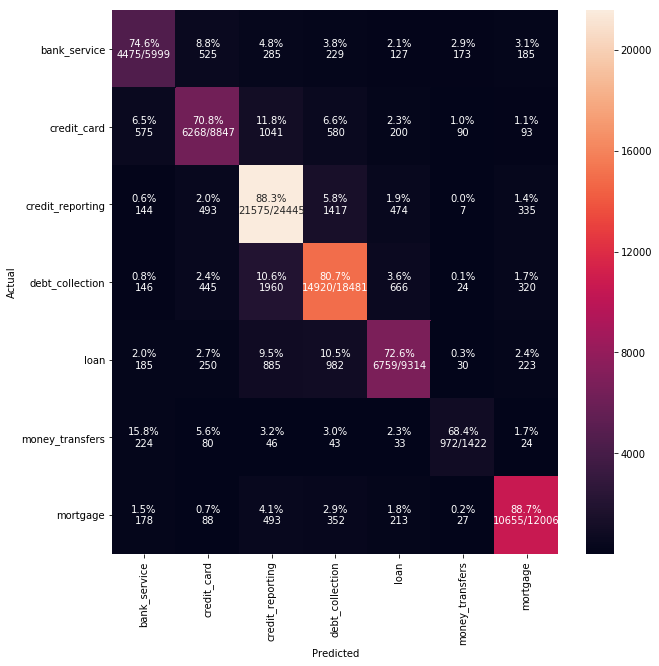

In [101]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

result = svm_clf.score(text_bow_test, y_test)
y_pred = svm_clf.predict(text_bow_test)

cm_analysis(y_test, y_pred, svm_clf.classes_, ymap=None, figsize=(10,10))

In [105]:
features = vectorizer.get_feature_names()
print(metrics.classification_report(y_test, predicted, target_names=features))

                  precision    recall  f1-score   support

    bank_service       0.77      0.73      0.75      5999
     credit_card       0.77      0.70      0.74      8847
credit_reporting       0.83      0.87      0.85     24445
 debt_collection       0.81      0.80      0.81     18481
            loan       0.74      0.76      0.75      9314
 money_transfers       0.73      0.69      0.71      1422
        mortgage       0.90      0.88      0.89     12006

     avg / total       0.81      0.81      0.81     80514



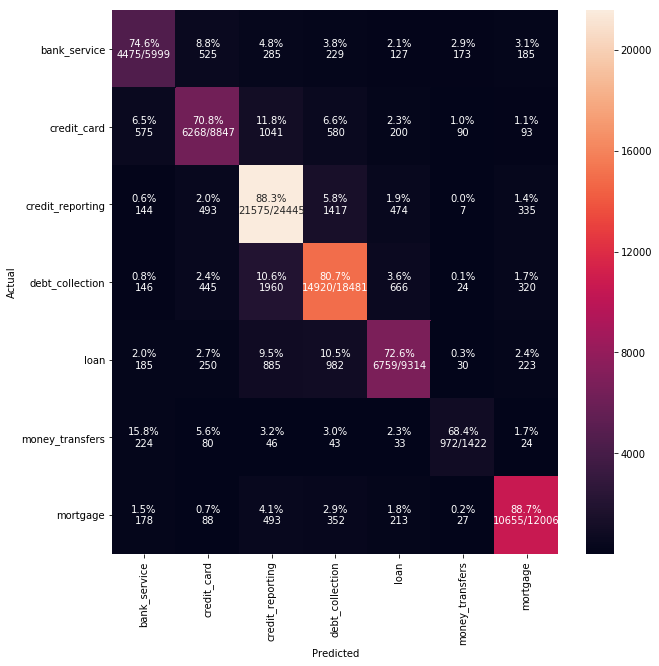

In [96]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

cm_analysis(y_test, y_pred, svm_clf.classes_, ymap=None, figsize=(10,10))

In [133]:
from io import StringIO
df = corps
df = df[pd.notnull(df['product_group'])]
df.columns = ['product_group','complaint_id', 'text']
df['complaint_id'] = df['product_group'].factorize()[0]
category_id_df = df[['product_group', 'complaint_id']].drop_duplicates().sort_values('complaint_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['complaint_id', 'product_group']].values)

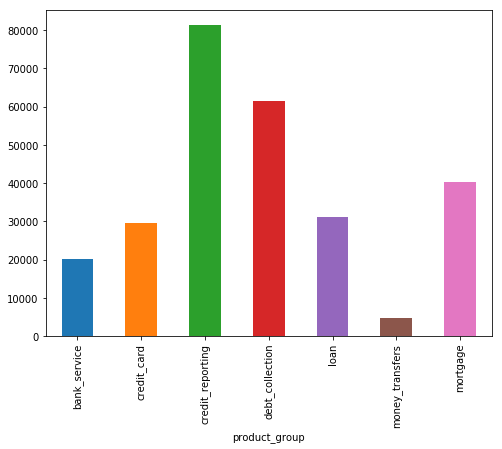

In [134]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
corps.groupby('product_group').text.count().plot.bar(ylim=0)
plt.show()

In [108]:
from sklearn.feature_selection import chi2
import numpy as np
tfidf= TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(X_train) #CORRECT TRANSFORM
labels = y_train #CORRECT LABEL
for product_group, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == product_group)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(product_group))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n.  {}".format('\n. '.join(bigrams[-N:])))
  print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# 'bank_service':
  . Most correlated unigrams:
. deposit
. overdraft
  . Most correlated bigrams:
.  overdraft fees
. checking account
  . Most correlated trigrams:
. charged overdraft fees
. opened checking account
# 'credit_card':
  . Most correlated unigrams:
. express
. card
  . Most correlated bigrams:
.  american express
. credit card
  . Most correlated trigrams:
. credit card account
. credit card company
# 'credit_reporting':
  . Most correlated unigrams:
. experian
. equifax
  . Most correlated bigrams:
.  credit file
. credit report
  . Most correlated trigrams:
. mistakes appear report
. appear report understanding
# 'debt_collection':
  . Most correlated unigrams:
. collection
. debt
  . Most correlated bigrams:
.  collect debt
. collection agency
  . Most correlated trigrams:
. attempting collect debt
. trying collect debt
# 'loan':
  . Most correlated unigrams:
. loans
. navient
  . Most correlated bigrams:
.  student loans
. student loan
  . Most correlated trigrams:
.

In [26]:
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_train=bow_transformer.transform(X_train)#ONLY TRAINING DATA

In [27]:
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_test=bow_transformer.transform(X_test)#TEST DATA

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

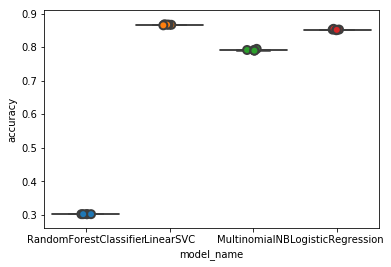

In [140]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

# 9. Model Analysis

Now we turn to our analysis of the models output and performance.

### 9.1. Anlysis of Model Performance

To start with, we can see on the graph above our models from lef to
right: the random forest classification model, the support vector
machine (SVM), the multinomial Bayes classification mode, and the
multinomial logistic regression model. From the graph it appears that
the SVM provides the best performance. This is supported by the model
accuracy metric shown below, with about 98%.

In [141]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.866703
LogisticRegression        0.852177
MultinomialNB             0.791452
RandomForestClassifier    0.302338
Name: accuracy, dtype: float64

In [147]:
model = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(text_bow_train, y_train)
y_pred = model.predict(text_bow_test)

### 9.2. Confusion Matrix

Here, we cut to the chase and look at the confusion matrix provided by
the SVM. Although we show the confusion matrix, the normalized confusion
matrix is more informative (section 9.3).


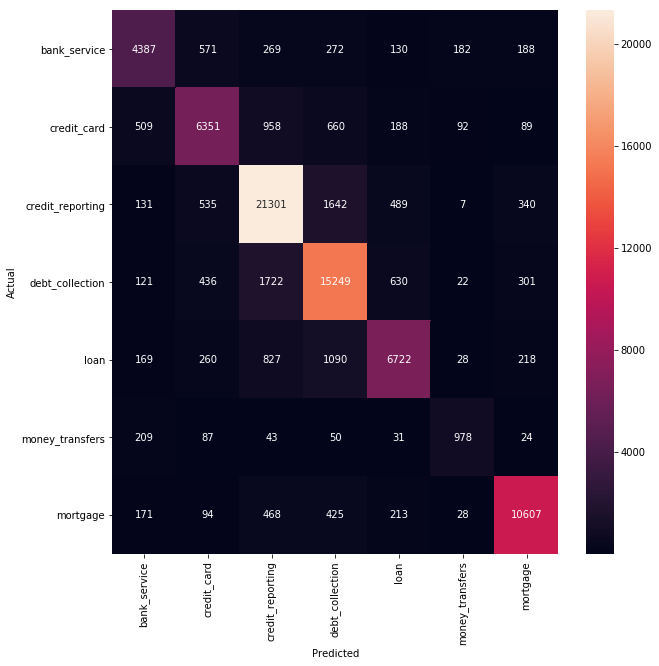

In [148]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 9.3. Normalized Confusion Matrix

Given the matrix below and 96.653% accuracy:

* 'Bank Service' is accurately 74.4% of the time, and incorrectly
classifies as a 'credit card' complaint 9.0% of the time, as a 'credit reporting' complaint 4.5% of the time, and so on, as we move left to right on row one..
* 'Credit Card' is accurately 70.9% of the time, and is
incorrectly classified as a 'credit reporting' complaint 11.3% of the time,
as a 'debt c0llection' complaint 7.4 of the time, so on.
* 'Credit Reporting' is accurately 87.6% of the time, and incorrectly
classified as a 'debt collection, complaint 6.6% of the time, as a 'loan' complaint 8.9% of the time, and so on.
* 'Debt Collection' is accurately 82.3% of the time, and incorrectly classied as a 'loan' 3.2% of the time, as a  'money transfer' complaint 0.1% of the time, and so on.
* 'Money Transfers' is accurately 68.3% of the time, and incorrectly classified as a 'mortgage' complaint 1.7% of the time, as a 'bank service' complaint 16.0% of the time and so on.
* 'Mortgages' is accurately 88.6% of the time, and incorrectly
classified as a 'bank service' complaint 1.5% of the time, as a 'credit card' pmplaint 0.7%" of the time,
and so on..

Accuracy - 81.4%, Recall = 77.7%, Precision is 79.8%, and the F1 Score is 78.7%

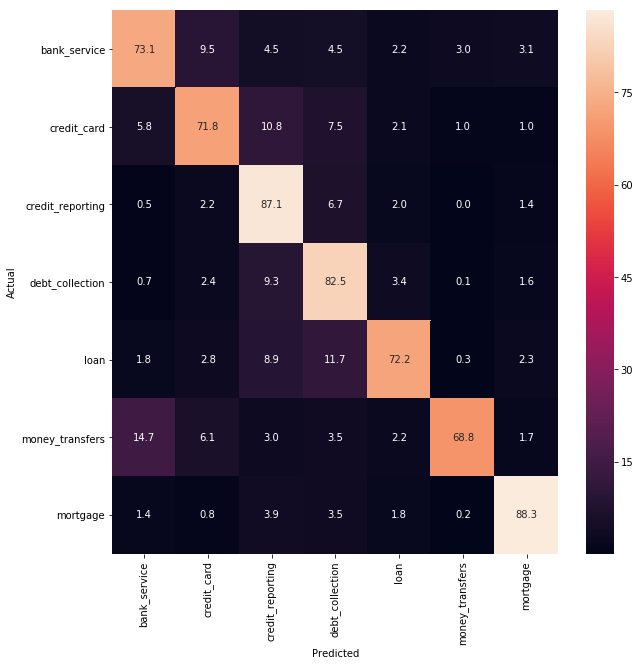

In [149]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / conf_sum.astype(float) * 100
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(cm_perc, annot=True, fmt='.1f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [154]:
result = model.score(text_bow_test, y_test)
print("Accuracy: %.3f%%" % (result*100.0))
y_pred = model.predict(text_bow_test)
print("F1 Score: ", f1_score(y_test, y_pred, average="macro"))
print("Precision Score: ", precision_score(y_test, y_pred, average="macro"))
print("Recall Score: ", recall_score(y_test, y_pred, average="macro")) 


Accuracy: 81.470%
F1 Score:  0.7866339972684333
Precision Score:  0.7977073485433834
Recall Score:  0.7769441913593736


Neural Network Model

In [ ]:
from sklearn.neural_network import MLPClassifier
MLPClassifier()
mlp_clf = fit(text_bow_train, y_train)
y_pred = model.predict(text_bow_test)

## Training the Multinomial Naive Bayes Model:

Multinomial Naive Bayes Algorithm (Classifier) has been used as the Classification Machine Learning Algorithm [1].

In [30]:
from sklearn.naive_bayes import MultinomialNB
#mnb_clf2 = MultinomialNB().fit(X_train_tfidf, y_train)

In [31]:
X_train.size, text_bow_train.size, y_train.size

(187866, 11571246, 187866)

In [188]:
# Importing necessary libraries
from sklearn.naive_bayes import MultinomialNB

# instantiating the model with Multinomial Naive Bayes..
clf_bayes = MultinomialNB()

# training the model...
clf_bayes = clf_bayes.fit(text_bow_train, y_train)

In [189]:
clf_bayes.score(text_bow_train, y_train)

0.8205210096558185

### Model Performance Analysis:

#### Training Accuracy

In [190]:
X_train.size, text_bow_train.size, y_train.size

(187866, 16606894, 187866)

In [191]:
X_test.size, text_bow_test.size, y_test.size

(80514, 7105300, 80514)

In [192]:
bayes_score = clf_bayes.score(text_bow_test, y_test)
bayes_score

0.8103683831383361

#### Validation Accuracy

In [193]:
bayes_val_score = clf_bayes.score(text_bow_test, y_test)
bayes_val_score

0.8103683831383361

The cross-validation score is very close to the model score, 80.99 versus 82.44. The naive Bayes model is a good fit of the data and will produce good predictions.


### Precision, Recall and F1–Score

In [194]:
# Importing necessary libraries
from sklearn.metrics import classification_report
 
# getting the predictions of the Validation Set...
bayes_preds = clf_bayes.predict(text_bow_test)

# getting the Precision, Recall, F1-Score
print(classification_report(y_test,bayes_preds))

                  precision    recall  f1-score   support

    bank_service       0.76      0.81      0.79      5999
     credit_card       0.72      0.76      0.74      8847
credit_reporting       0.82      0.83      0.83     24445
 debt_collection       0.83      0.76      0.80     18481
            loan       0.74      0.78      0.76      9314
 money_transfers       0.86      0.63      0.73      1422
        mortgage       0.90      0.91      0.91     12006

     avg / total       0.81      0.81      0.81     80514



### Naive Bayes Predictions

In [195]:
bayes_preds[0:10]

array(['credit_reporting', 'credit_card', 'credit_reporting',
       'credit_card', 'mortgage', 'credit_reporting', 'credit_card',
       'debt_collection', 'credit_reporting', 'credit_reporting'],
      dtype='<U16')

In [196]:
clf_bayes.predict_proba(text_bow_test)

array([[1.19471968e-069, 3.84825362e-059, 1.00000000e+000, ...,
        4.05905093e-075, 6.26352819e-100, 1.35682028e-075],
       [2.65981241e-006, 9.96373617e-001, 3.62368475e-003, ...,
        2.24623683e-011, 1.40632014e-012, 6.55350400e-013],
       [4.96685001e-028, 3.07831191e-026, 1.00000000e+000, ...,
        2.65483820e-024, 1.51581818e-031, 1.93698158e-032],
       ...,
       [1.15726961e-004, 9.99884273e-001, 8.72676065e-018, ...,
        4.68769863e-014, 4.25399169e-015, 4.84876377e-016],
       [6.36199380e-001, 6.51378999e-005, 2.62588749e-004, ...,
        9.24394504e-014, 2.33038443e-016, 1.40803630e-015],
       [4.31957518e-060, 1.20736961e-063, 9.04539612e-023, ...,
        9.06738683e-047, 2.02824344e-089, 1.01267752e-018]])

### Confusion Matrix

Confusion matrix, without normalization
[[ 4885   538   181    98    76    83   138]
 [  573  6751   854   345   222    36    66]
 [  148  1018 20411  1473   944     8   443]
 [  116   517  2397 14088   997     7   359]
 [  181   281   671   712  7253     5   211]
 [  365    94    12    20    19   900    12]
 [  129   115   333   185   281     5 10958]]


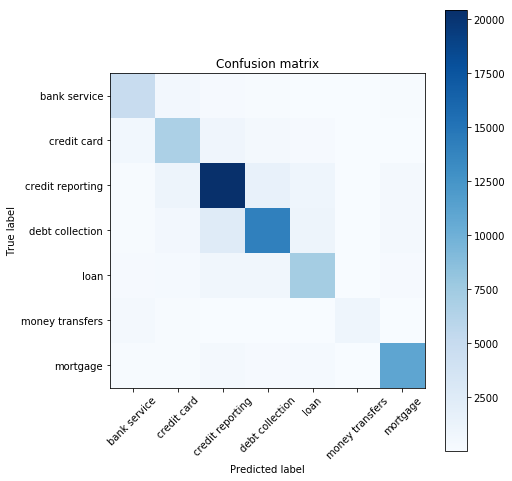

In [259]:
# Compute confusion matrix
cm = confusion_matrix(y_test,bayes_preds)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, classes=['bank service','credit card','credit reporting','debt collection','loan','money transfers','mortgage'])

In [256]:
from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[8.14e-01 8.97e-02 3.02e-02 1.63e-02 1.27e-02 1.38e-02 2.30e-02]
 [6.48e-02 7.63e-01 9.65e-02 3.90e-02 2.51e-02 4.07e-03 7.46e-03]
 [6.05e-03 4.16e-02 8.35e-01 6.03e-02 3.86e-02 3.27e-04 1.81e-02]
 [6.28e-03 2.80e-02 1.30e-01 7.62e-01 5.39e-02 3.79e-04 1.94e-02]
 [1.94e-02 3.02e-02 7.20e-02 7.64e-02 7.79e-01 5.37e-04 2.27e-02]
 [2.57e-01 6.61e-02 8.44e-03 1.41e-02 1.34e-02 6.33e-01 8.44e-03]
 [1.07e-02 9.58e-03 2.77e-02 1.54e-02 2.34e-02 4.16e-04 9.13e-01]]


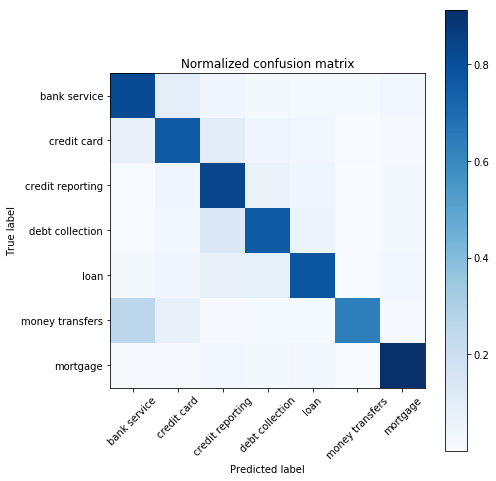

In [260]:
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#fig, ax = plt.subplots(figsize=(6,6))
#sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=features, yticklabels=features)
print(cm_normalized)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm_normalized, 
        classes=['bank service','credit card','credit reporting','debt collection','loan','money transfers','mortgage'],
        title='Normalized confusion matrix')
plt.show()

# Training the Classification Tree Model

In [200]:
from sklearn import tree
clf_class = tree.DecisionTreeClassifier()
clf_class = clf_class.fit(text_bow_train, y_train)

In [201]:
clf_class

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Classification Tree Scores

In [50]:
from sklearn import tree

In [51]:
tree_score = clf_class.score(text_bow_train, y_train)
tree_score

0.9991802667859006

In [52]:
tree_val_score = clf_class.score(text_bow_test, y_test)
tree_val_score

0.7502794545048066

The cross-validation score is much lower than the model score, 75.83 versus 99.91. The classificaton tree model is over-fitting the data and will produce numerous false positives.


### Classification Tree Predictions

In [53]:
tree_preds = clf_class.predict(text_bow_test)
tree_preds[0:10]

array(['credit_reporting', 'credit_card', 'credit_reporting',
       'credit_card', 'mortgage', 'credit_reporting', 'credit_reporting',
       'debt_collection', 'credit_reporting', 'credit_reporting'],
      dtype=object)

In [54]:
clf_class.predict_proba(text_bow_test)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Tree Summary

According to the Performance Analysis, we can conclude that this model may be overfitting the data, given th significant difference wetween train and test scores. 
- Train: 99.91% 
- Test: 75.94%

# Training the Random Forest Model

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [56]:
clf_rf = RandomForestClassifier(n_estimators=100) # initialize
clf_rf.fit(text_bow_train, y_train) # fit the data to the algorithm

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Random Forest Model Scores

In [64]:
forest_score = clf_rf.score(text_bow_train, y_train)
forest_score

0.9991802667859006

In [65]:
forest_val_score = clf_rf.score(text_bow_test, y_test)
forest_val_score

0.8230618277566635

In [59]:
clf_rf.get_params(clf_rf.fit)

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Random Forest Predictions

In [60]:
forest_preds = clf_rf.predict(text_bow_test)
forest_preds[0:10]

array(['credit_reporting', 'credit_card', 'credit_reporting',
       'credit_card', 'mortgage', 'credit_reporting', 'credit_reporting',
       'debt_collection', 'credit_reporting', 'credit_reporting'],
      dtype=object)

In [61]:
clf_rf.predict_proba(text_bow_test)[0:10]

array([[0.03, 0.09, 0.57, 0.24, 0.04, 0.  , 0.03],
       [0.04, 0.39, 0.21, 0.18, 0.08, 0.01, 0.09],
       [0.01, 0.02, 0.88, 0.06, 0.03, 0.  , 0.  ],
       [0.05, 0.47, 0.17, 0.21, 0.02, 0.02, 0.06],
       [0.06, 0.09, 0.15, 0.08, 0.1 , 0.03, 0.49],
       [0.  , 0.02, 0.91, 0.04, 0.01, 0.  , 0.02],
       [0.12, 0.2 , 0.48, 0.11, 0.04, 0.03, 0.02],
       [0.03, 0.11, 0.34, 0.46, 0.05, 0.  , 0.01],
       [0.03, 0.09, 0.47, 0.26, 0.08, 0.02, 0.05],
       [0.08, 0.07, 0.58, 0.1 , 0.03, 0.  , 0.14]])

### Random Forest Summary

The random forest model is probably over-fitting the data and will produce numerous false positives. The cross-validation score is much lower than the model score. 
- Train: 99.91. 
- Test: 82.45  

# Model Comparisons

In [62]:
bayes_preds[0:20], tree_preds[0:20], forest_preds[0:20]

(array(['credit_reporting', 'credit_card', 'credit_reporting',
        'credit_card', 'mortgage', 'credit_reporting', 'bank_service',
        'debt_collection', 'credit_reporting', 'credit_reporting',
        'bank_service', 'debt_collection', 'credit_reporting', 'loan',
        'credit_card', 'loan', 'credit_reporting', 'mortgage', 'mortgage',
        'loan'], dtype='<U16'),
 array(['credit_reporting', 'credit_card', 'credit_reporting',
        'credit_card', 'mortgage', 'credit_reporting', 'credit_reporting',
        'debt_collection', 'credit_reporting', 'credit_reporting',
        'bank_service', 'debt_collection', 'credit_reporting', 'loan',
        'credit_card', 'loan', 'credit_reporting', 'mortgage', 'mortgage',
        'loan'], dtype=object),
 array(['credit_reporting', 'credit_card', 'credit_reporting',
        'credit_card', 'mortgage', 'credit_reporting', 'credit_reporting',
        'debt_collection', 'credit_reporting', 'credit_reporting',
        'bank_service', 'debt_col

In [66]:
bayes_score, bayes_val_score, tree_score, tree_val_score, forest_score, forest_val_score

(0.8131132473855479,
 0.8131132473855479,
 0.9991802667859006,
 0.7502794545048066,
 0.9991802667859006,
 0.8230618277566635)

# Conclusion

- The Classification and Random Forest models will have a tendency to over-predict. 
- While the Naive Bayes was trained having a lower performnce score (82,44),it will have more accurate predictions. 
- If we had an out-of-time sample, we could perform better validations on the three models. 
- In the mean time, we recommend the Naive Bayes Classification MOdel. 

## Backup Material

#### Legend
- 0 = bank service
- 1 = credit card
- 2 = credit reporting
- 3 = debt collection
- 4 = loan
- 5 = money transfers
- 6 = mortgage

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
comp=bow_transformer.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])
print(model.predict(comp))

['debt_collection']


In [49]:
comp2=bow_transformer.transform(["someone stole my credit card and used it at walmart. I received a credit card alert on my mastercard."])
print(model.predict(comp2))

['credit_card']


In [88]:
comp3=bow_transformer.transform(["I am trying tos get a second morgage. the rate on my original mortgage is high."])
print(model.predict(comp3))

['mortgage']


In [89]:
comp3=bow_transformer.transform(["I wanted to get a loan to purchase a new car, but they said my credit score was too low due to other outstanding loans. I don't see what the big deal is with having other loans."])
print(model.predict(comp3))

['loan']


## Multi-layer Perceptron Classifier

In [163]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 4), random_state=1)
mlpc.fit(text_bow_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

### MLPClassifier Scores
#### *Training Accuracy*

In [164]:
MLPC_score = mlpc.score(text_bow_train, y_train)
MLPC_score

0.7123321942235423

#### Validation Accuracy

In [165]:
MLPC_val_score = mlpc.score(text_bow_test, y_test)
MLPC_val_score

0.7049208833246392

The cross-validation score is very close to the model score, 88.21 versus 81.87. The naive Bayes model is a good fit of the data and will produce good predictions.

## Multi-class Support Vector Machine

In [44]:
from sklearn import svm
svm_class = svm.LinearSVC()
svm_class.fit(text_bow_train, y_train) 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### SVM Scores
#### *Training Accuracy*

In [45]:
SVM_score = svm_class.score(text_bow_train, y_train)
SVM_score

0.9570012668604218

#### *Validation Accuracy*

In [46]:
SVM_val_score = svm_class.score(text_bow_test, y_test)
SVM_val_score

0.8096852721265867

#### *SVM Predictions*

In [47]:
svm_pred = svm_class.predict(text_bow_test)
svm_pred

array(['credit_reporting', 'credit_card', 'credit_reporting', ...,
       'credit_card', 'debt_collection', 'debt_collection'], dtype=object)

In [48]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, svm_pred)

In [50]:
df = corps
df = df[pd.notnull(df['product_group'])]
df.columns = ['product_group','complaint_id', 'text']
df['complaint_id'] = df['product_group'].factorize()[0]
category_id_df = df[['product_group', 'complaint_id']].drop_duplicates().sort_values('complaint_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['complaint_id', 'product_group']].values)
df.head()

,product_group,complaint_id,text
0,2815595,0,On check was debited from checking account and...
1,2217937,1,opened a Bank of the the West account The acc...
2,2657456,2,in nj opened a business account without autho...
3,1414106,3,A hold was placed on saving account because in...
4,1999158,4,Dear CFPBneed to send a major concerncomplaint...


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
features = tfidf_transformer.fit_transform(text_bow_train)
labels = text_bow_train

In [60]:
#svm_class = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
svm_class = svm.LinearSVC()
svm_class.fit(text_bow_train, y_train)
y_pred = svm_class.predict(text_bow_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [61]:
plt.show()

The cross-validation score is very close to the model score, 94.32 versus 81.25. The naive Bayes model is a good fit of the data and will produce good predictions.


# PART II. Multi-Class Text Classification

## 7. Data Exploration and Preparation

As we stated in paragraph 3, we perform Multi-Class Text Classification
using a number of models, including a support vector machine (SVM),
multinomial Bayes classification mode, random forest classification
model, and a multinomial logistic regression model. Our goal here is to
get a better outcome than afforded by our initial analysis (Part I).

### 7.1. Data Exploration

Before diving into training our machine learning models, we take another
look at the distribution of complaints in each class using a histogram.


### 7.2. Data Preparation

As before, we first prepare the text for analysis by Vectorizing it,
although we do it here differently in order to use the text in our
various models more effectively.

### 7.3. Checking the Data

Here we choose to check our vectorized data using Chi-Square testing and
examining unigrams and bigrams for each SCRA Issue (class). This will
give us an idea of the most important words and pair of words in the
text as they pertain to classification of complaints. Note that ``Well
Fargo'' is a bigram for ``Excessive Interest'' Perhaps suprisingly,
``"Well Fargo'' appears in the transcripts of USAA SCRA calls, probably
due to the high interest rates they were demanding from service members.
As a result of these violations, we should take care to note these as we
discuss SCRA with our members, who may have formally sought loans from
Wells Fargo, for instance. The other unigrams and bigrams should be
apparent.


## 8. Model Development and Execution

Here we prepare to implement and run our four models.

### 8.1. Model Preparation

As before, we define training and test sets and prepare them for a BOW
analysis with our models.


### 8.2. Model Execution

Now we setup and run the four models uing our BOWs.

## 9. Model Analysis

Now we turn to our analysis of the models output and performance.

### 9.1. Anlysis of Model Performance

To start with, we can see on the graph above our models from lef to
right: the random forest classification model, the support vector
machine (SVM), the multinomial Bayes classification mode, and the
multinomial logistic regression model. From the graph it appears that
the SVM provides the best performance. This is supported by the model
accuracy metric shown below, with about 98%.

### 9.2. Confusion Matrix

Here, we cut to the chase and look at the confusion matrix provided by
the SVM. Although we show the confusion matrix, the normalized confusion
matrix is more informative (section 9.3).


9.4. Anecdotal Evidence

For anecdotal evidence, we printed out five excerpt from the predicted
data. All are well within reason, provided the resullts shown by the
confussion matrix.

9.5. Unigrams and Bigrams

Notice the similaries and differences between with our earlier analysis.

9.6. Detailed Metrics

The following provides the details that we summarized in section 9.3.